In [1]:
from collections import Counter

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
from IPython import display
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**ЧАСТЬ 1. Подготовка данных**

In [3]:
dfTrue = pd.read_csv('/content/drive/MyDrive/NLP/True.csv')
dfTrue.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
dfTrue1 = dfTrue.copy()
dfTrue1['Class'] = int(1)
dfTrue1.head()

,title,text,subject,date,Class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
dfFake = pd.read_csv('/content/drive/MyDrive/NLP/Fake.csv')
dfFake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
dfFake0 = dfFake.copy()
dfFake0['Class'] = int(0)
dfFake0.head()

,title,text,subject,date,Class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
# Объединённый датасет
df_combined = pd.concat([dfTrue1, dfFake0], ignore_index=True)
df = df_combined.sample(frac=1).reset_index(drop=True)
df.head(10)


,title,text,subject,date,Class
0,U.N. rights boss urges U.S. Congress to give '...,GENEVA (Reuters) - The top U.N. human rights o...,worldnews,"September 11, 2017",1
1,Trump likely to rescind Obama 'Dreamer' progra...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"August 25, 2017",1
2,Suspected Boko Haram suicide bombers kill at l...,"BAUCHI, Nigeria (Reuters) - Suspected Boko Har...",worldnews,"December 2, 2017",1
3,Pittsburgh Mayor Slaps Trump Down For Using P...,The mayor of Pittsburgh had a few choice words...,News,"June 1, 2017",0
4,Thailand seeks air safety rating upgrade by U....,BANGKOK (Reuters) - Thailand aims to get its a...,worldnews,"December 20, 2017",1
5,Two gay men challenge Tennessee denial of serv...,(Reuters) - Two men have filed a lawsuit again...,politicsNews,"June 8, 2016",1
6,China's Chongqing renews attacks on former dis...,BEIJING (Reuters) - The government of the sout...,worldnews,"November 20, 2017",1
7,Nigeria ex-vice president prepared to run for ...,ABUJA (Reuters) - Nigeria s former Vice Presid...,worldnews,"November 24, 2017",1
8,TRUMP’S STATEMENT On Muslim Immigration Is Spo...,Donald Trump: With fifty people dead and perha...,left-news,"Jun 13, 2016",0
9,Germany's Gabriel denies report he is eyeing f...,BERLIN (Reuters) - German Foreign Minister Sig...,worldnews,"December 9, 2017",1


In [8]:
df['Class'].values[4]

1

In [9]:
len(df)

44898

In [10]:
texts = df['title'].values[:35000]
labels = df['Class'].values[:35000]

In [11]:
texts

array(["U.N. rights boss urges U.S. Congress to give 'Dreamers' legal status",
       "Trump likely to rescind Obama 'Dreamer' program: media reports",
       'Suspected Boko Haram suicide bombers kill at least 13 in Nigeria: officials',
       ...,
       ' Sean Spicer Dreams Up Brand-New Fake Terrorist Attack To Defend Trump’s Muslim Ban',
       'Ground Zero Mosque Was NOT Defeated: Three Story Islamic Museum And Muslim Prayer Space Will Take Its Place [Video]',
       'THE ULTIMATE HYPOCRITE: Who Are The Billionaires Funding Campaign Of Candidate Who Mocks…Billionaires'],
      dtype=object)

In [12]:
texts_test = df['title'].values[35000:]
labels_test = df['Class'].values[35000:]

**ЧАСТЬ 2. Токенизация и представление каждого токена в виде вектора с помощью one-hot кодирования**

In [13]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [14]:
counter = Counter()

for text in texts:
    counter.update(tokenizer.tokenize(text.lower()))

tokens = set([token for token, count in counter.items() if count > 5])

token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [15]:
len(token_to_idx)

6964

In [16]:
def text_to_bow(text):
    bow = np.zeros(len(token_to_idx))

    for token in tokenizer.tokenize(text):
        if token in tokens:
            bow[token_to_idx[token]] += 1
    return bow

In [17]:
texts[3]

' Pittsburgh Mayor Slaps Trump Down For Using Pittsburgh As A Reason To Destroy The Planet'

In [18]:
text_to_bow(texts[3])

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
sum(text_to_bow(texts[3]))

0.0

In [20]:
len(tokenizer.tokenize(texts[3]))

15

In [21]:
[(token in tokens) for token in tokenizer.tokenize(texts[3])]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [22]:
Counter(labels)

Counter({1: 16672, 0: 18328})

In [23]:
X_train_bow = np.stack(list(map(text_to_bow, texts)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

**ЧАСТЬ 3. Логистическая регрессия**

In [24]:
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, labels)

train accuracy 0.9938857142857143
test accuracy 0.9863608809860578


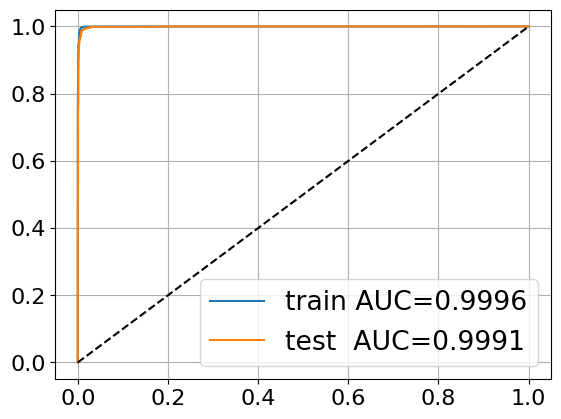

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

for name, X, y, model in [
    ('train', X_train_bow, labels, bow_model),
    ('test ', X_test_bow, labels_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

print('train accuracy', accuracy_score(model.predict(X_train_bow), labels))
print('test accuracy', accuracy_score(model.predict(X_test_bow), labels_test))



**ЧАСТЬ 4. Создание и обучение нейросети**

In [26]:
X_train_bow.shape, X_test_bow.shape

((35000, 6964), (9898, 6964))

In [27]:
NUM_FEATURES = len(tokens)

In [28]:
model = nn.Sequential()
model.add_module('dropout', nn.Dropout(p=0.8))
model.add_module('l1', nn.Linear(NUM_FEATURES, 16))
model.add_module('relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.8))
model.add_module('l2', nn.Linear(16, 2))
model.add_module('logit', nn.Sigmoid())

In [29]:
loss_function = nn.CrossEntropyLoss()

In [30]:
opt = torch.optim.RMSprop(model.parameters(), lr=1e-2)

In [31]:
X_train_bow_torch = torch.FloatTensor(X_train_bow)
X_test_bow_torch = torch.FloatTensor(X_test_bow)

y_train_torch = torch.LongTensor(labels)
y_test_torch = torch.LongTensor(labels_test)

In [32]:
n_iterations = 2000
batch_size = 256
train_loss_history = []
train_acc_history = []
plot_history = []
test_plot_history = []

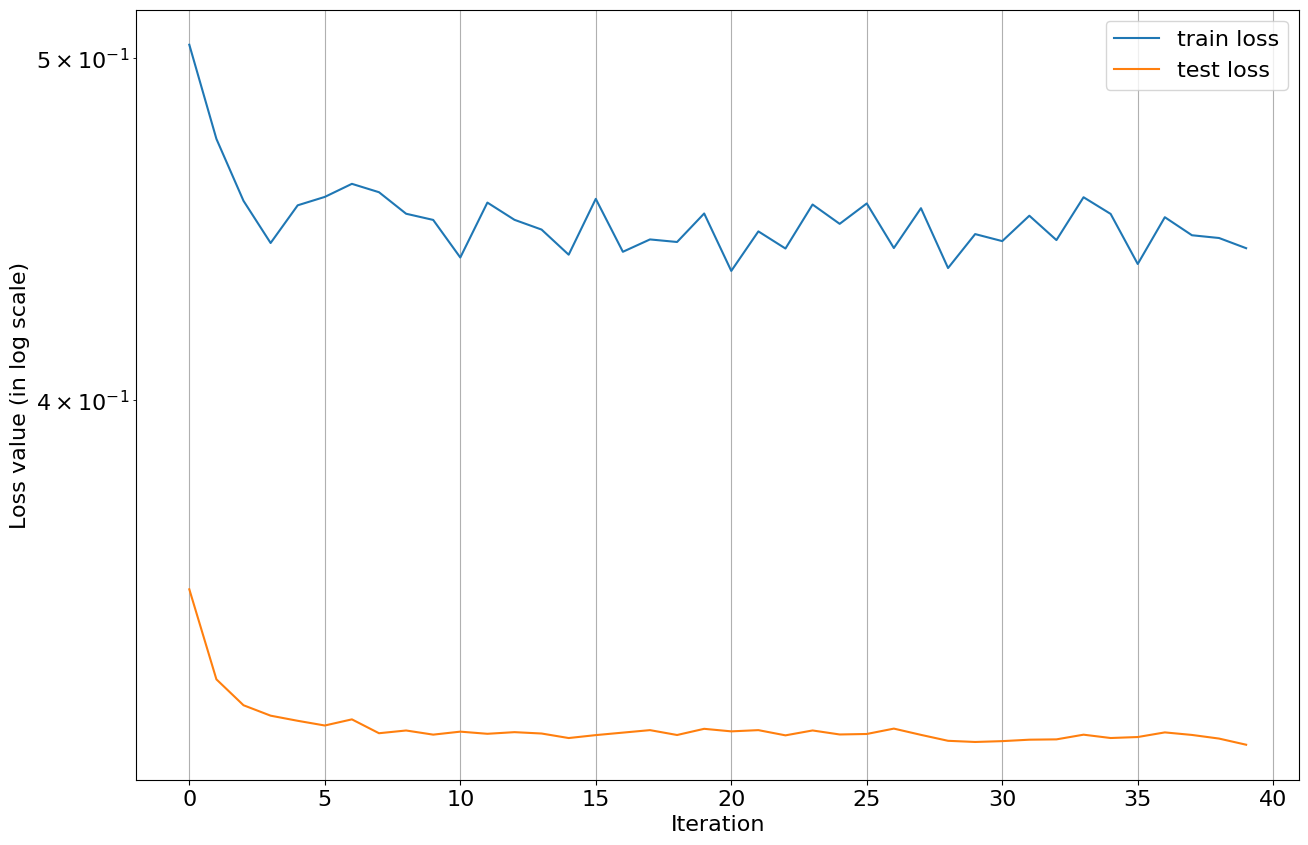

In [33]:
for _i in range(n_iterations):
    model.train()
    opt.zero_grad()

    ix = np.random.randint(0, len(X_train_bow_torch), batch_size)
    x_batch = X_train_bow_torch[ix]
    y_batch = y_train_torch[ix]

    y_predicted = model(x_batch)
    loss = loss_function(y_predicted, y_batch)
    loss.backward()
    opt.step()

    train_loss_history.append(loss.data.numpy())
    train_acc_history.append(
        accuracy_score(
            y_batch.detach().numpy(),
            y_predicted.detach().numpy().argmax(axis=1)
        )
    )

    if (_i+25) % 50==0:
        model.eval()
        plot_history.append(np.mean(train_loss_history[-10:]))
        test_plot_history.append(loss_function(model(X_test_bow_torch), y_test_torch).item())


        display.clear_output(True)
        plt.figure(figsize=(15, 10))
        plt.plot(plot_history, label='train loss')
        plt.plot(test_plot_history, label='test loss')
        plt.yscale('log')
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Loss value (in log scale)')
        plt.legend()
        plt.show()

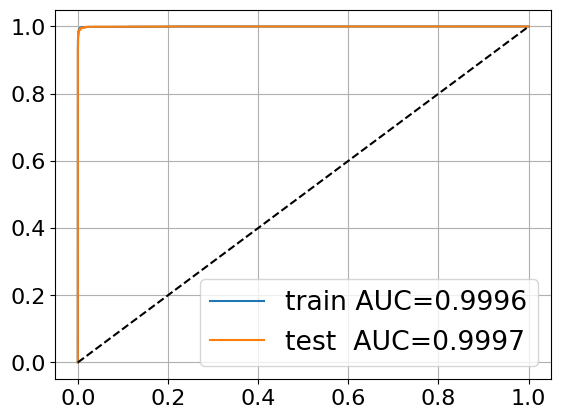

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, labels, model),
    ('test ', X_test_bow_torch, labels_test, model)
]:
    model.eval()
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [35]:
train_predictions = torch.max(model(X_train_bow_torch).detach().cpu(), dim=1)[1].numpy()
test_predictions = torch.max(model(X_test_bow_torch).detach().cpu(), dim=1)[1].numpy()

print('train accuracy', accuracy_score(train_predictions, labels))
print('test accuracy', accuracy_score(test_predictions, labels_test))

train accuracy 0.9949142857142858
test accuracy 0.9936350777934936


**ЧАСТЬ 5. Тесты для новостей не из датасета**

In [36]:
# Функция для проверки принадлежности к классу для отдельной новости

def check_of_class (other_test):

  counter.update(tokenizer.tokenize(text.lower()))
  tokens = set([token for token, count in counter.items() if count > 5])
  token_to_idx = {token: idx for idx, token in enumerate(tokens)}

  input_tensor = torch.FloatTensor(text_to_bow(other_test))
  model.eval()  # Переводим модель в режим оценки (для отключения Dropout и BatchNorm, если они есть)
  with torch.no_grad():  # Отключаем вычисление градиентов, чтобы ускорить предсказания
    output = model(input_tensor)

  if output[0] > output[1]:
    prediction = 'Fake'
  else:
    prediction = 'True'

  return prediction

#FAKE NEWS

In [37]:
#Fake
new_test = 'Hillary Clinton becomes the US President'
print(check_of_class(new_test))

Fake


In [38]:
#Fake
new_test = 'Donald Trump Is Changing His Campaign Slogan to Prove He’s Not Racist'
print(check_of_class(new_test))

Fake


In [39]:
#Fake
new_test = 'Brexit Encourages UK to Trade With Non-EU States, Including Russia'
print(check_of_class(new_test))

Fake


In [40]:
#Fake
new_test = 'Israeli ministry paid for propaganda using fake social media accounts to get weapons from the US'
print(check_of_class(new_test))

True


In [41]:
#Fake
new_test = 'Jaden Smith Says He is a Prophet and God Inspired his New Fashion Line 666'
print(check_of_class(new_test))

Fake


#TRUE NEWS

In [42]:
#True
new_test = 'Musk flexes influence over Congress in shutdown drama'
print(check_of_class(new_test))

True


In [43]:
#True
new_test = 'Amazon to start paying US warehouse workers double time for all overtime hours'
print(check_of_class(new_test))

True


In [48]:
new_test = 'Amazon will start paying US warehouse workers double pay for overtime hours'
print(check_of_class(new_test))

True


In [44]:
#True
new_test = 'Will Smith and Chris Rock have a history that predates the Oscars slap '
print(check_of_class(new_test))

Fake


In [50]:
#True
new_test = 'How Argentina won the 2022 World Cup, in their own words'
print(check_of_class(new_test))

True


In [46]:
#True
new_test = ' A single winning ticket for the $2.04 billion Powerball jackpot was sold in California'
print(check_of_class(new_test))

True
